In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
import seaborn as sns
from datetime import datetime

data = pd.read_csv("../../data/data_export.csv")

data["cited_by_count"] = pd.to_numeric(data["cited_by_count"], errors="coerce")
data['publication_date'] = pd.to_datetime(data['publication_date'], errors='coerce')
current_date = datetime.now()
data['months_since_publication'] = data['publication_date'].apply(
    lambda date: (current_date.year - date.year) * 12 + (current_date.month - date.month) if pd.notnull(date) else None
)

data["log_cited_by_count"] = np.log1p(data["cited_by_count"])

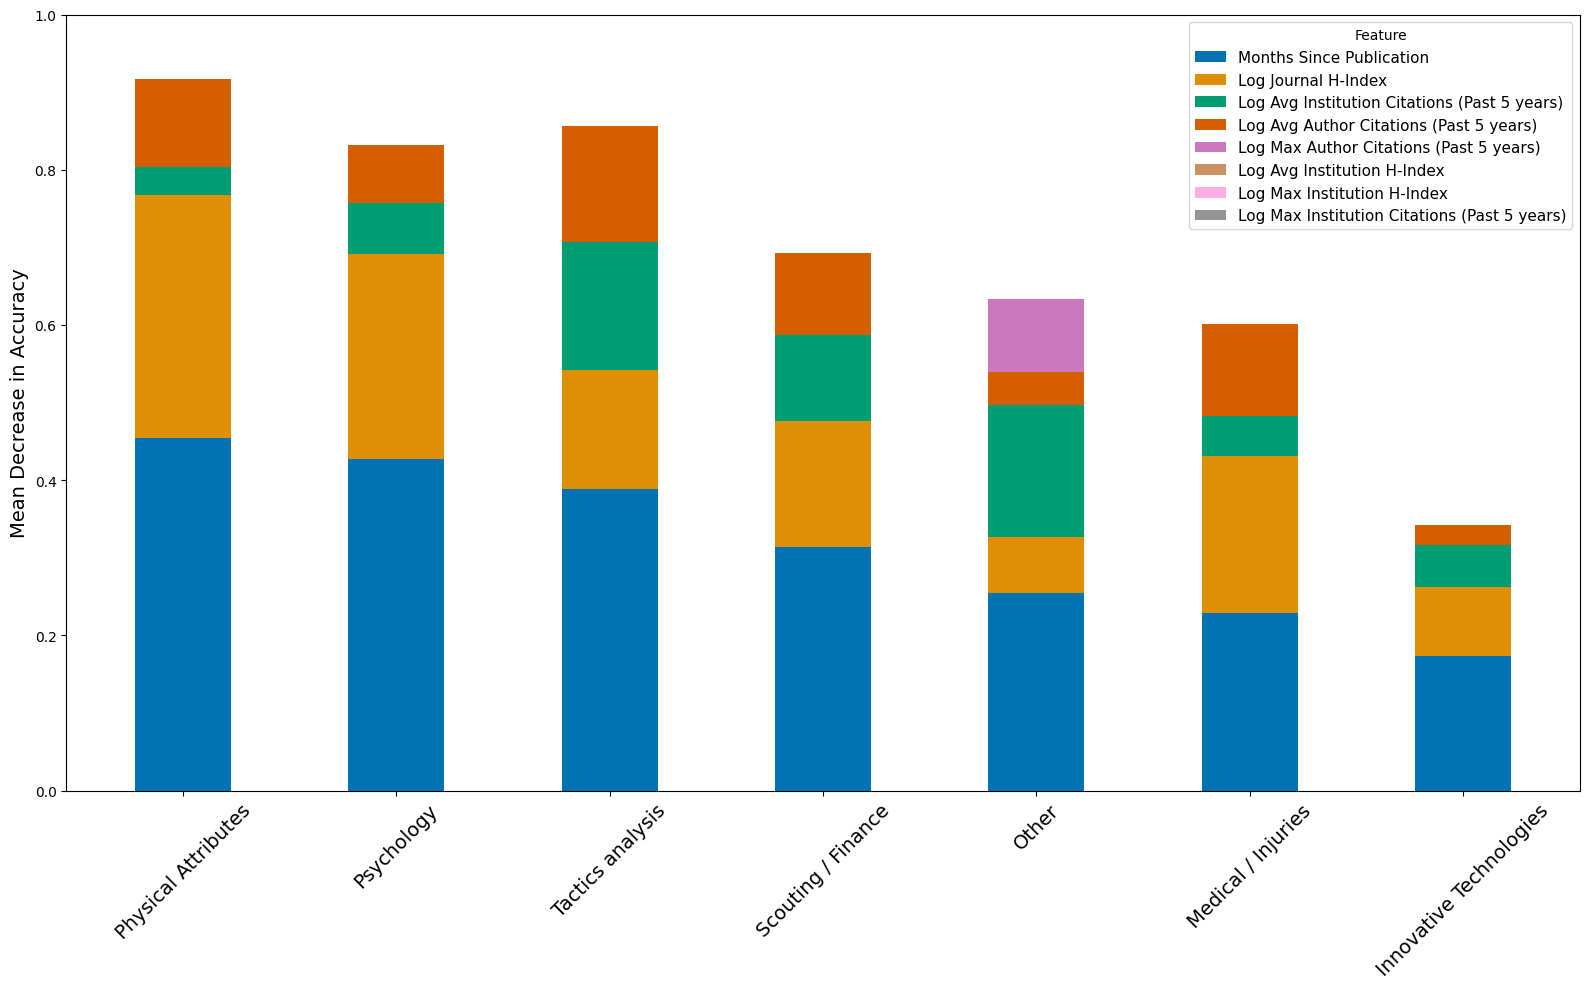

In [2]:
features = [
    'avg_author_h_index',
    'max_author_h_index',
    'journal_h_index',
    'avg_institution_h_index',
    'max_institution_h_index',
    'avg_author_citations_past_5_years',
    'max_author_citations_past_5_years',
    'avg_institution_citations_past_5_years',
    'max_institution_citations_past_5_years',
    'months_since_publication'
]
feature_labels = {
    'log_avg_author_h_index': 'Log Avg Author H-Index',
    'log_max_author_h_index': 'Log Max Author H-Index',
    'log_journal_h_index': 'Log Journal H-Index',
    'log_avg_institution_h_index': 'Log Avg Institution H-Index',
    'log_max_institution_h_index': 'Log Max Institution H-Index',
    'log_avg_author_citations_past_5_years': "Log Avg Author Citations (Past 5 years)",
    'log_max_author_citations_past_5_years': 'Log Max Author Citations (Past 5 years)',
    'log_avg_institution_citations_past_5_years': 'Log Avg Institution Citations (Past 5 years)',
    'log_max_institution_citations_past_5_years': 'Log Max Institution Citations (Past 5 years)',
    'months_since_publication': "Months Since Publication",
}

log_transformed_features = []
for feature in features:
    if feature != 'months_since_publication':  
        log_feature_name = f"log_{feature}"
        data[log_feature_name] = np.log1p(data[feature])  # Log-transform feature
        log_transformed_features.append(log_feature_name)
    else:
        log_transformed_features.append(feature)  # Keep 'months_since_publication' unchanged

features = log_transformed_features


importance_data = []

categories = data['predicted_category'].unique()
for category in categories:
    subset = data[data['predicted_category'] == category]

    X = subset[features]
    y = subset['log_cited_by_count']

    rf = RandomForestRegressor(random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=5)
    rfe.fit(X, y)
    selected_features = [feature for feature, rank in zip(features, rfe.ranking_) if rank == 1]

    X_selected = subset[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=True)
    rf_selected = RandomForestRegressor(random_state=42)
    rf_selected.fit(X_train, y_train)

    perm_importance = permutation_importance(rf_selected, X_test, y_test, random_state=42, n_repeats=100)
    importance_values = perm_importance.importances_mean

    feature_importance_dict = {'Category': category}
    for feature, importance in zip(selected_features, importance_values):
        feature_importance_dict[feature] = importance

    importance_data.append(feature_importance_dict)

importance_df = pd.DataFrame(importance_data)

renamed_features = {f: feature_labels[f] for f in features if f in feature_labels}
importance_df = importance_df.rename(columns=renamed_features)

importance_df['Total Importance'] = importance_df.iloc[:, 1:].sum(axis=1)
importance_df = importance_df.sort_values(by='Total Importance', ascending=False)

feature_totals = importance_df.iloc[:, 1:-1].sum(axis=0).sort_values(ascending=False)
sorted_features = feature_totals.index.tolist()  # most important features will be at the bottom
colors = sns.color_palette("colorblind", len(sorted_features))
importance_df = importance_df[['Category'] + sorted_features + ['Total Importance']]

categories = importance_df['Category']
x = np.arange(len(categories))
bar_width = 0.45

plt.figure(figsize=(16, 10))
bottom_values = np.zeros(len(categories))

for i, feature in enumerate(sorted_features):
    plt.bar(x, importance_df[feature], bottom=bottom_values, label=feature, width=bar_width, color=colors[i])
    bottom_values += importance_df[feature]

plt.xticks(x, categories, rotation=45, ha='center', fontsize=14)
plt.ylabel('Mean Decrease in Accuracy', fontsize=14)
# plt.title('Feature Import ance by Predicted Category (Top Features Ordered by Relevance)')
plt.legend(title='Feature', loc='upper right', fontsize=11)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("feature_importance_sorted_bottom.png", dpi=400)
plt.show()

In [3]:
importance_df

,Category,Months Since Publication,Log Journal H-Index,Log Avg Institution Citations (Past 5 years),Log Avg Author Citations (Past 5 years),Log Max Author Citations (Past 5 years),Log Avg Institution H-Index,Log Max Institution H-Index,Log Max Institution Citations (Past 5 years),Total Importance
0,Physical Attributes,0.454455,0.313227,0.036041,0.113681,NaN,0.019282,NaN,NaN,0.936686
6,Psychology,0.427643,0.263488,0.065507,0.075637,NaN,NaN,0.027846,NaN,0.860121
4,Tactics analysis,0.387995,0.154423,0.164691,0.149163,NaN,NaN,NaN,-0.013119,0.843154
2,Scouting / Finance,0.313739,0.162483,0.110754,0.105816,NaN,0.018250,NaN,NaN,0.711041
3,Other,0.254278,0.072193,0.170440,0.042977,0.093625,NaN,NaN,NaN,0.633514
5,Medical / Injuries,0.228229,0.203014,0.051382,0.118927,NaN,0.004664,NaN,NaN,0.606217
1,Innovative Technologies,0.173453,0.088910,0.054105,0.025259,NaN,-0.010112,NaN,NaN,0.331614


In [26]:
from sklearn.metrics import r2_score

y_pred = rf_selected.predict(X_test)
print("R^2 Score:", r2_score(y_test, y_pred))


R^2 Score: 0.5525622360366116


/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


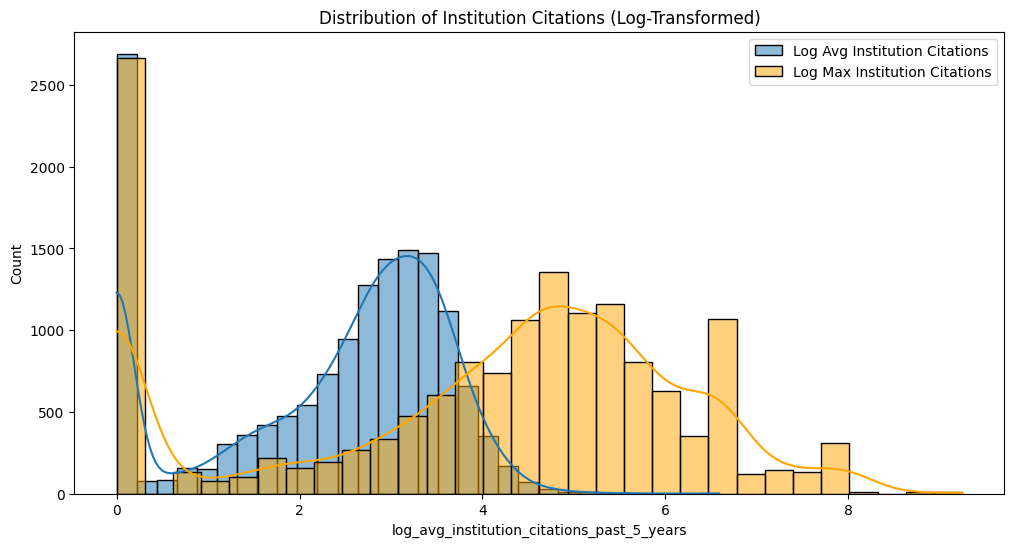

In [2]:
data['log_avg_institution_citations_past_5_years'] = np.log1p(data['avg_institution_citations_past_5_years'])
data['log_max_institution_citations_past_5_years'] = np.log1p(data['max_institution_citations_past_5_years'])

plt.figure(figsize=(12, 6))
sns.histplot(data['log_avg_institution_citations_past_5_years'], bins=30, kde=True, label='Log Avg Institution Citations')
sns.histplot(data['log_max_institution_citations_past_5_years'], bins=30, kde=True, color='orange', label='Log Max Institution Citations')
plt.legend()
plt.title('Distribution of Institution Citations (Log-Transformed)')
plt.show()

/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/franekl/.local/share/virtualenvs/profile-lab-hnW9b1nV/

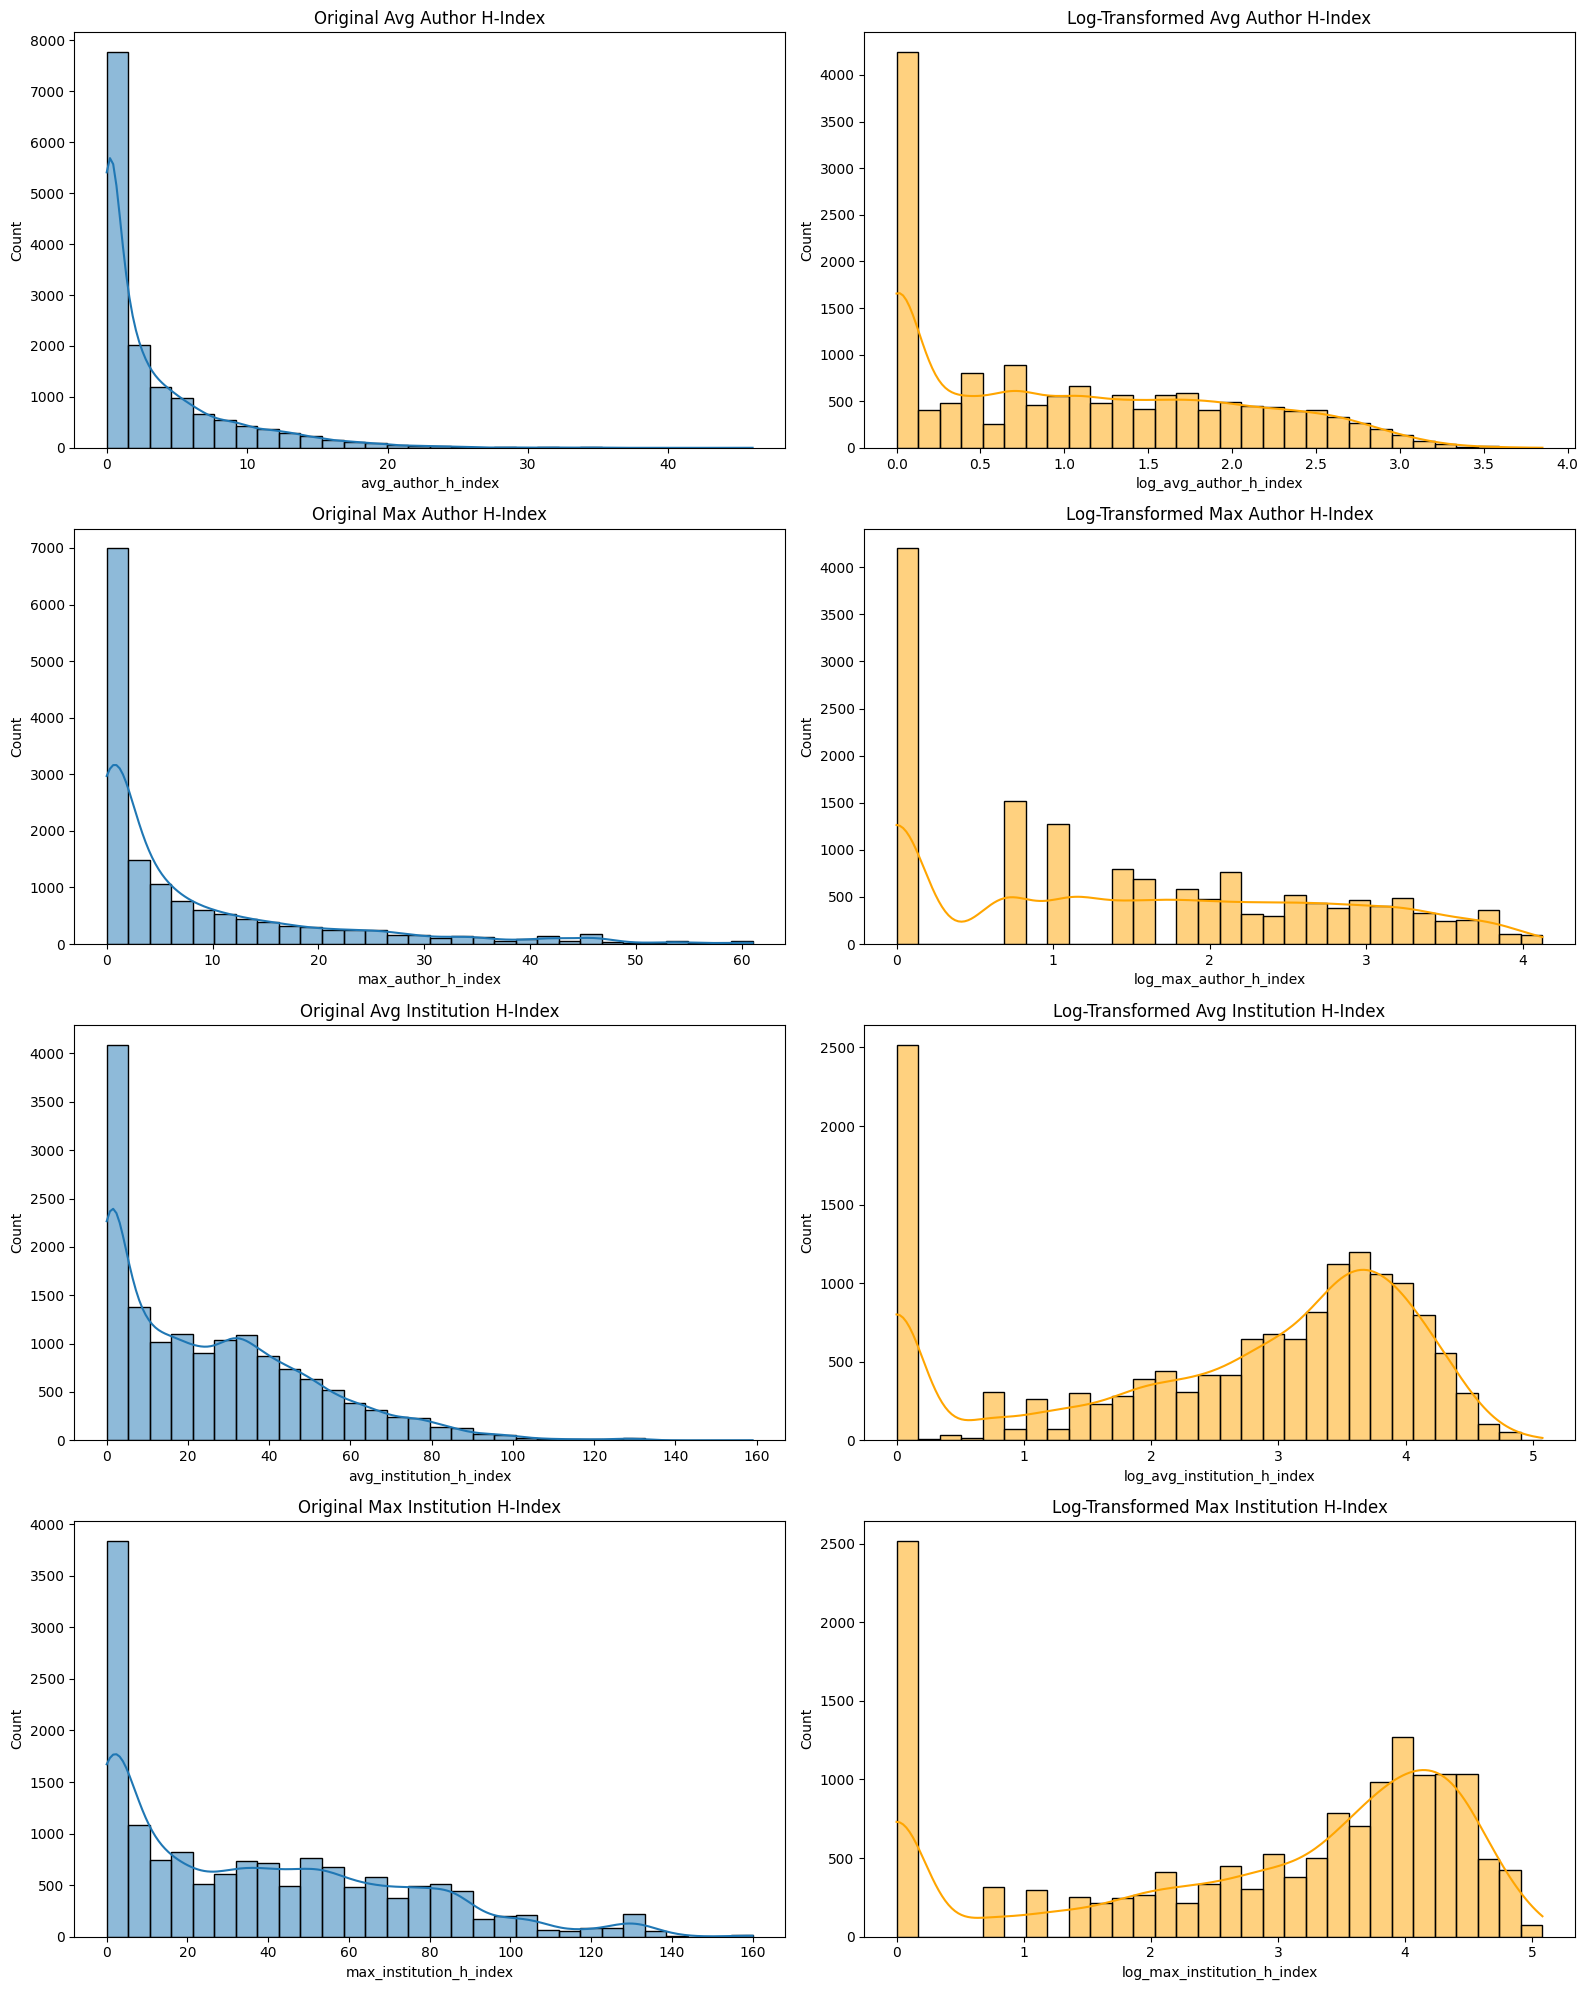

Original Avg Author H-Index: 0.3489
Log Avg Author H-Index: 0.3930
Original Max Author H-Index: 0.3488
Log Max Author H-Index: 0.4012
Original Avg Institution H-Index: 0.3215
Log Avg Institution H-Index: 0.3635
Original Max Institution H-Index: 0.3608
Log Max Institution H-Index: 0.3795


In [16]:
data['log_avg_author_h_index'] = np.log1p(data['avg_author_h_index'])
data['log_max_author_h_index'] = np.log1p(data['max_author_h_index'])
data['log_avg_institution_h_index'] = np.log1p(data['avg_institution_h_index'])
data['log_max_institution_h_index'] = np.log1p(data['max_institution_h_index'])

fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Avg Author H-Index
sns.histplot(data['avg_author_h_index'], bins=30, kde=True, ax=axes[0, 0], label='Original Avg Author H-Index')
axes[0, 0].set_title('Original Avg Author H-Index')
sns.histplot(data['log_avg_author_h_index'], bins=30, kde=True, ax=axes[0, 1], color='orange', label='Log Avg Author H-Index')
axes[0, 1].set_title('Log-Transformed Avg Author H-Index')

# Max Author H-Index
sns.histplot(data['max_author_h_index'], bins=30, kde=True, ax=axes[1, 0], label='Original Max Author H-Index')
axes[1, 0].set_title('Original Max Author H-Index')
sns.histplot(data['log_max_author_h_index'], bins=30, kde=True, ax=axes[1, 1], color='orange', label='Log Max Author H-Index')
axes[1, 1].set_title('Log-Transformed Max Author H-Index')

# Avg Institution H-Index
sns.histplot(data['avg_institution_h_index'], bins=30, kde=True, ax=axes[2, 0], label='Original Avg Institution H-Index')
axes[2, 0].set_title('Original Avg Institution H-Index')
sns.histplot(data['log_avg_institution_h_index'], bins=30, kde=True, ax=axes[2, 1], color='orange', label='Log Avg Institution H-Index')
axes[2, 1].set_title('Log-Transformed Avg Institution H-Index')

# Max Institution H-Index
sns.histplot(data['max_institution_h_index'], bins=30, kde=True, ax=axes[3, 0], label='Original Max Institution H-Index')
axes[3, 0].set_title('Original Max Institution H-Index')
sns.histplot(data['log_max_institution_h_index'], bins=30, kde=True, ax=axes[3, 1], color='orange', label='Log Max Institution H-Index')
axes[3, 1].set_title('Log-Transformed Max Institution H-Index')

plt.tight_layout()
plt.show()

correlations = {
    'Original Avg Author H-Index': data['avg_author_h_index'].corr(data['log_cited_by_count']),
    'Log Avg Author H-Index': data['log_avg_author_h_index'].corr(data['log_cited_by_count']),
    'Original Max Author H-Index': data['max_author_h_index'].corr(data['log_cited_by_count']),
    'Log Max Author H-Index': data['log_max_author_h_index'].corr(data['log_cited_by_count']),
    'Original Avg Institution H-Index': data['avg_institution_h_index'].corr(data['log_cited_by_count']),
    'Log Avg Institution H-Index': data['log_avg_institution_h_index'].corr(data['log_cited_by_count']),
    'Original Max Institution H-Index': data['max_institution_h_index'].corr(data['log_cited_by_count']),
    'Log Max Institution H-Index': data['log_max_institution_h_index'].corr(data['log_cited_by_count']),
}

for key, value in correlations.items():
    print(f"{key}: {value:.4f}")

In [14]:
correlation_original_avg = data['avg_institution_citations_past_5_years'].corr(data['log_cited_by_count'])
correlation_log_avg = data['log_avg_institution_citations_past_5_years'].corr(data['log_cited_by_count'])

correlation_original_max = data['max_institution_citations_past_5_years'].corr(data['log_cited_by_count'])
correlation_log_max = data['log_max_institution_citations_past_5_years'].corr(data['log_cited_by_count'])

print(f"Correlation (Original Avg): {correlation_original_avg}")
print(f"Correlation (Log Avg): {correlation_log_avg}")
print(f"Correlation (Original Max): {correlation_original_max}")
print(f"Correlation (Log Max): {correlation_log_max}")


Correlation (Original Avg): 0.43918690395908055
Correlation (Log Avg): 0.4724137446236707
Correlation (Original Max): 0.23295719303079684
Correlation (Log Max): 0.4135027699535161


In [2]:
# data = data[data['publication_year']<2023]

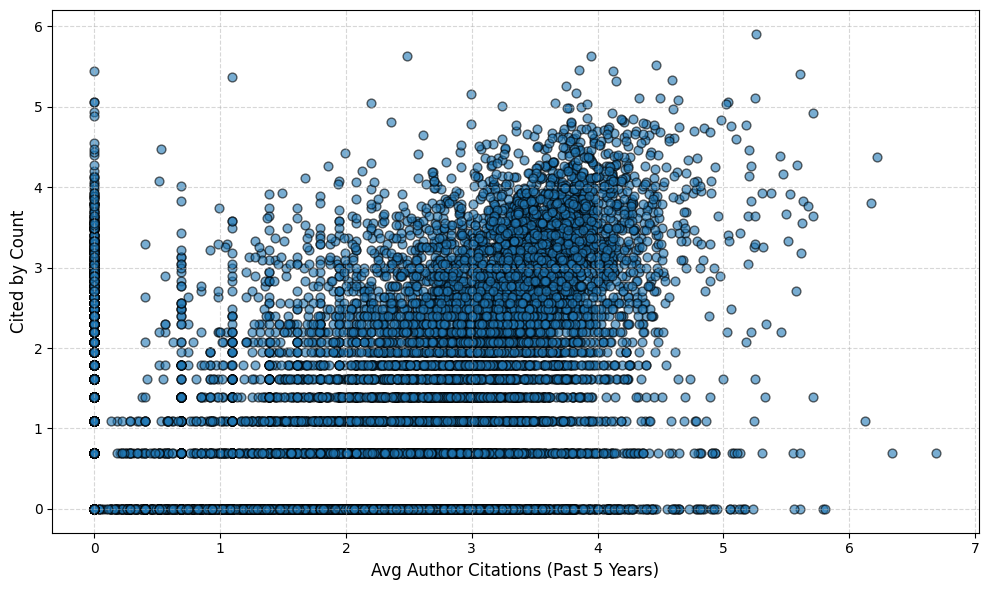

In [16]:
plt.figure(figsize=(10, 6))

# Extract relevant columns for plotting
x = data['log_avg_author_citations_past_5_years']
y = data['log_cited_by_count']

plt.scatter(x, y, alpha=0.6, edgecolor='k', s=40)
plt.xlabel('Avg Author Citations (Past 5 Years)', fontsize=12)
plt.ylabel('Cited by Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



In [ ]:
plt.figure(figsize=(10, 6))

# Extract relevant columns for plotting
x = data['avg_author_citations_past_5_years']
y = data['cited_by_count']

plt.scatter(x, y, alpha=0.6, edgecolor='k', s=40)
plt.xlabel('Avg Author Citations (Past 5 Years)', fontsize=12)
plt.ylabel('Cited by Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



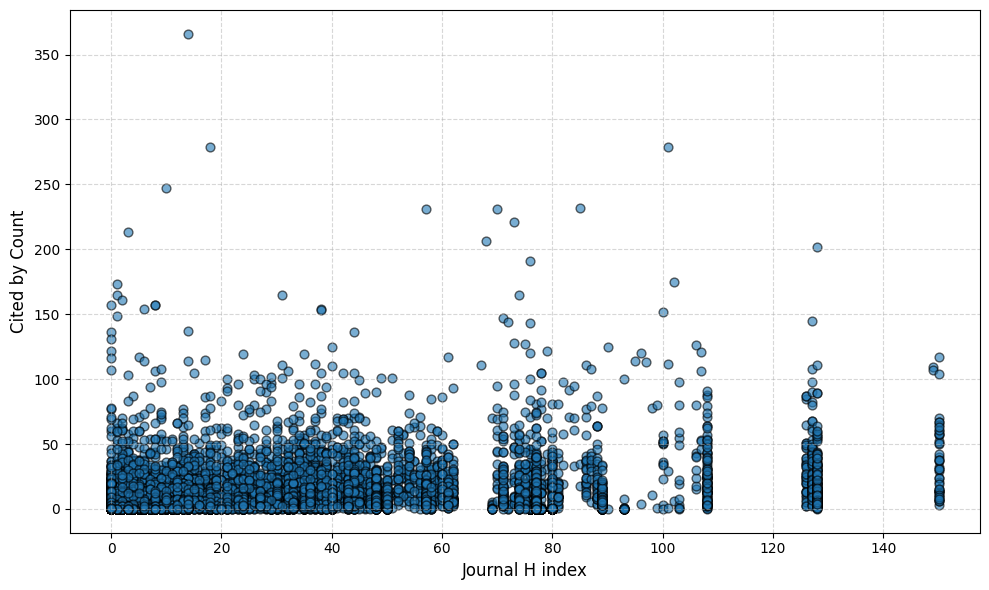

In [13]:
plt.figure(figsize=(10, 6))

# Extract relevant columns for plotting
x = data['journal_h_index']
y = data['cited_by_count']

plt.scatter(x, y, alpha=0.6, edgecolor='k', s=40)
plt.xlabel('Journal H index', fontsize=12)
plt.ylabel('Cited by Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()